In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
import torch
import numpy as np
from tqdm import tqdm

from datetime import datetime

In [ ]:
from CVUSA_dataset import CVUSA_dataset_cropped, CVUSA_Dataset_Eval
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset




transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
])


# data_path = '/media/fahimul/2B721C03261BDC8D/Research/datasets/CVUSA' #don't include the / at the end
# data_path = '/home/fa947945/datasets/CVUSA_Cropped/CVUSA' #don't include the / at the end
data_path = '/data/Research/Dataset/CVUSA_Cropped/CVUSA' #don't include the / at the end

train_data= pd.read_csv(f'{data_path}/splits/train-19zl.csv')
train_ds = CVUSA_dataset_cropped(df = train_data, path=data_path, transform=transform)

anchor_img, positive_img, negative_img = train_ds[0]

anchor_img = anchor_img.permute(1, 2, 0)
positive_img = positive_img.permute(1, 2, 0)
negative_img = negative_img.permute(1, 2, 0)

# plt.imshow(anchor_img.numpy())

# plt.imshow(positive_img.numpy())


# train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)




plt.subplot(1, 3, 1)
plt.imshow(anchor_img)
plt.title('anchor_img')
plt.axis('off')

# Plotting the second image
plt.subplot(1, 3, 2)
plt.imshow(positive_img)
plt.title('positive_img')
plt.axis('off')

# Plotting the third image
# plt.subplot(1, 3, 3)
# plt.imshow(negative_img)
# plt.title('negative_img')
# plt.axis('off')

plt.show()


In [ ]:
a = torch.rand(1, 128, 96, 96)
b = torch.rand(1, 128, 96, 96)
# b = torch.rand(1, 256, 48, 48)
c = torch.rand(1, 512, 24, 24)
d = torch.rand(1, 1024, 12, 12)

query_features = list([a,b])

reference_features = list([a,b,c,d])

for i in query_features:
    print(i.shape)

In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from torchsummary import summary
from models.clip_b32 import getClipModel
import torch.optim as optim
from losses import SoftTripletBiLoss
from custom_models import ResNet, VIT, CLIP_model


img1 = torch.rand(124, 3, 224, 224).cuda()
img2 = torch.rand(124, 3, 224, 224).cuda()



# from resnet_model import ResNet

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Device: {device}")
# model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
crit = SoftTripletBiLoss()
model1 = CLIP_model()
model2 = getClipModel()
# para1 = list(filter(lambda p: p.requires_grad, model1.parameters()))
# para2 = list(filter(lambda p: p.requires_grad, model1.parameters()))
# para = para1.append(para2)
# opti = optim.SGD(para, lr=0.001)
# emb1 = model1.encode_image(img1)
# emb2 = model2.encode_image(img2)
# for param in model1.parameters():
#     param.requires_grad = False


for name, param in model1.named_parameters():
    if param.requires_grad:
        print(name, param.data)




# print(model2)





In [1]:
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPVisionModel
from CVUSA_dataset import CVUSA_dataset_cropped, CVUSA_Dataset_Eval
from torch.utils.data import DataLoader
import pandas as pd
from torchvision import transforms
from tqdm import tqdm
from custom_models import CLIP_model
from eval import predict, accuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
model = CLIP_model()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# url = "/data/Research/Dataset/CVUSA_Cropped/CVUSA/streetview/panos/0000001.jpg"
# image = Image.open(url).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_path = '/data/Research/Dataset/CVUSA_Cropped/CVUSA' #don't include the / at the end
train_data= pd.read_csv(f'{data_path}/splits/train-19zl.csv')
train_ds = CVUSA_dataset_cropped(df = train_data, path=data_path, transform=transform)
val_que = CVUSA_Dataset_Eval(data_folder=data_path, split='train', img_type='query', transforms=transform)
val_ref = CVUSA_Dataset_Eval(data_folder=data_path, split='train', img_type='reference', transforms=transform)

train_load = DataLoader(train_ds, batch_size=32, shuffle=False)
val_loader_que = DataLoader(val_que, batch_size=32, shuffle=False)
val_loader_ref = DataLoader(val_ref, batch_size=32, shuffle=False)

def get_vision_embeddings(img):
    # Preprocess the images
    img = img.to(device)
    temp_dic = {'pixel_values':img}
    # Use the CLIP model to get vision embeddings
    with torch.no_grad():
        outputs = model(**temp_dic)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = outputs.pooler_output  # pooled CLS states
    return pooled_output


# img_features_list = []
# for idx, (img, label ) in enumerate(tqdm(val_loader_que)):
#     anchor_embedding = get_vision_embeddings(img)

#     img_features_list.append(anchor_embedding)
#     # print(anchor_embedding.shape)
# img_features = torch.cat(img_features_list, dim=0) 
# print(img_features.shape)

# for idx, (anchor, positive, negative) in enumerate(tqdm(train_load)):
#     anchor_embedding = get_vision_embeddings(anchor)
#     positive_embedding = get_vision_embeddings(positive)
#     print(anchor_embedding.shape)
#     print(positive_embedding.shape)

# print(anchor_embedding)

print("\nExtract Features:")
query_features, query_labels = predict(model=model, dataloader=val_loader_que, dev=device, isQuery=True)
reference_features, reference_labels = predict(model = model, dataloader=val_loader_ref, dev=device, isQuery=False) 



# print(query_features)


r1 =  accuracy(query_features=query_features, reference_features=reference_features, query_labels=query_labels, topk=[1, 5, 10])
    

/home/fahimul/.conda/envs/CVGL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fahimul/.conda/envs/CVGL/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/fahimul/.conda/envs/CVGL/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()



Extract Features:


100%|██████████| 334/334 [00:46<00:00,  7.18it/s]


query labels tensor([41073, 27458, 30398,  ...,  2868, 21150, 37911], device='cuda:0')
Percentage-top1:0.0, top5:0.04690871563936579, top10:0.09381743127873159, top1%:1.06951871657754, time:0.19825267791748047


In [ ]:
print(query_features)


r1 =  accuracy(query_features=query_features, reference_features=reference_features, query_labels=query_labels, topk=[1, 5, 10])


In [37]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPVisionModel
import torch

model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")
# input = torch.rand(32, 3, 224, 224)
# input = {'pixel_values':input}
# input

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled CLS states

inputs = inputs.pixel_values
inputs = torch.squeeze(inputs)
inputs.shape

/home/fahimul/.conda/envs/CVGL/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([3, 224, 224])

In [22]:
from transformers import tokenization_utils_base
import torch
from eval import predict, accuracy
import numpy as np

input = torch.rand(32, 3, 224, 224)

temp_queue = torch.randn(10659, 256)
temp_ref = torch.randn(10659, 256)

# ranking = np.sum((similarity[i,:]>similarity[i,i])*1.)

query_features_norm = np.sqrt(np.sum((temp_queue**2).numpy(), axis=1, keepdims=True))

# similarity = torch.randn(10, 10).numpy()
# for i in range(10):
#     ranking = np.sum((similarity[i,:]>similarity[i,i])*1.)



query_features_norm.shape

(10659, 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.models import vision_transformer
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights


# Load pre-trained ViT model
pretrained_vit = model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)


# Freeze the parameters of the pre-trained ViT model
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Define the number of output classes
num_classes = 10  # CIFAR-10 has 10 classes

# Define a custom classifier with an extra hidden layer
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Extract the input size of the pre-trained ViT model
# input_size = pretrained_vit.head.in_features

# Define the size of the hidden layer
# hidden_size = 512

# Create an instance of the custom classifier
# classifier = CustomClassifier(input_size, hidden_size, num_classes)

# Combine the pre-trained ViT model with the custom classifier
# model = nn.Sequential(pretrained_vit, classifier)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match ViT input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(model)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:    # Print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


In [ ]:
import math

dt = datetime.now()
f"{math.floor(dt.timestamp())}"[4:]

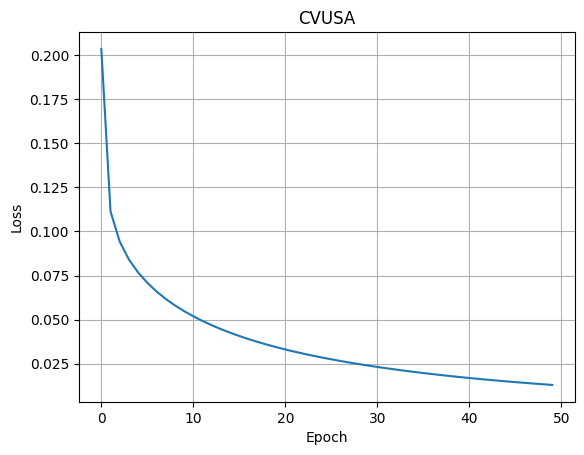

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/data/Research/CVGL_Baseline/losses/losses_5065290.csv')

# Assuming the first column is x-axis and the second column is y-axis
x = df.iloc[:, 0]
y = df.iloc[:, 1]

# Plotting
plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CVUSA' )
plt.grid(True)
plt.show()


In [ ]:
a = torch.rand(128, 1000)
b = torch.rand(128, 1000)


# a_norm = np.sqrt(np.sum(a**2, axis=1, keepdims=True))

a_norm = np.sqrt(np.sum((a**2).numpy(), axis=1, keepdims=True))
b_norm = np.sqrt(np.sum((b**2).numpy(), axis=1, keepdims=True))

sim = np.matmul(a/a_norm, (b/b_norm).T)

eyes_ = torch.eye(5).cuda()
print(eyes_)
pos_mask = eyes_.eq(0.5)
pos_mask

In [ ]:
import torch
import clip
n=5
m=10
inputs_q = torch.randn(n,m).cuda()
inputs_k = torch.randn(n,m).cuda()



n = inputs_q.size(0)

normalized_inputs_q = inputs_q / torch.norm(inputs_q, dim=1, keepdim=True)
normalized_inputs_k = inputs_k / torch.norm(inputs_k, dim=1, keepdim=True)
# normalized_inputs_q = inputs_q
# normalized_inputs_k = inputs_k
# print(normalized_inputs_q)
# print(normalized_inputs_k)


# # Compute similarity matrix
# sim_mat = torch.matmul(normalized_inputs_q, normalized_inputs_k.t())

# print(sim_mat)

sim_mat = normalized_inputs_q @ normalized_inputs_k.T

print(sim_mat)

# split the positive and negative pairs
eyes_ = torch.eye(n).cuda()

pos_mask = eyes_.eq(1)
neg_mask = ~pos_mask


pos_sim = torch.masked_select(sim_mat, pos_mask)
neg_sim = torch.masked_select(sim_mat, neg_mask)

# Contrastive loss of the example values
# temp parameter
t = 0.07
# concatenated vector divided by the temp parameter
for i in range(n):
    row = sim_mat[i]/t
    pos = row[i]

    exp = torch.exp(row)

    loss = -torch.log(pos/torch.sum(exp))
    print(loss)
    # #e^x of the values
    # exp = np.exp(logits)
    # # we only need to take the log of the positive value over the sum of exp. 
    # loss = - np.log(exp[0]/np.sum(exp))






# loss_batch = torch.log(1 + torch.exp((neg_sim_ - pos_sim_) * self.alpha))
# if torch.isnan(loss_batch).any():
#     print(inputs_q, inputs_k)
#     raise Exception

# loss = loss_batch.mean()

# mean_pos_sim = pos_sim.mean().item()
# mean_neg_sim = neg_sim.mean().item()
# loss, mean_pos_sim, mean_neg_sim


In [ ]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
output.backward()

In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
fet = []

# image = preprocess(Image.open("CLIP.jpg")).unsqueeze(0).to(device)
for i in range(5):
    image = torch.rand(64, 3, 224, 224)
    image = preprocess(image).unsqueeze(0).to(device)
    # text = clip.tokenize(["a diagram", "a dog", "a stallion"]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        fet.append(image)
        # text_features = model.encode_text(text)
    
#     logits_per_image, logits_per_text = model(image, text)
#     probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
